## Dataset Preprocessing

In [106]:
import pandas as pd
import scanpy as sc
import numpy as np

## IMPORT DATA AND READ FILES

In [115]:
adata = sc.read('adata.h5ad')
adata.var_names_make_unique()
#view data structure
adata

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 15000 × 38606
    obs: 'cell_id', 'project'
    var: 'gene_ids', 'feature_name', 'type'

## Preprocess Data And Visualization

In [116]:
#basic filtering to reduce zero genes and empty cells
sc.pp.filter_cells(adata,min_genes=200)
sc.pp.filter_genes(adata,min_cells=3)

In [117]:
#Make QC Metrics for Mitochondria, Ribosomal, and all Genes
adata.var['mt'] = adata.var.feature_name.str.startswith('MT-')
adata.var['rb'] = adata.var.feature_name.str.startswith('RP') & adata.var_names.str[2].isin(['S','L'])
sc.pp.calculate_qc_metrics(
    adata,qc_vars=['mt','rb'],percent_top=None,log1p=False,inplace=True
)

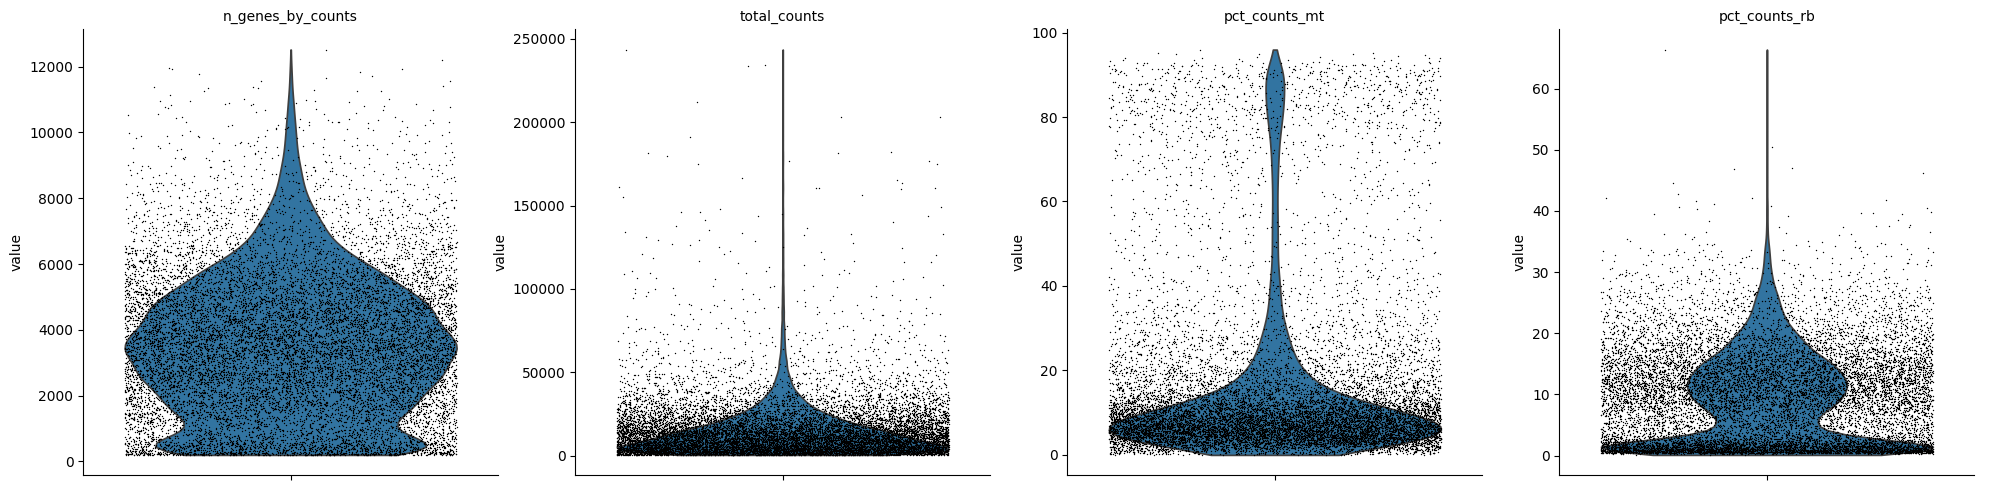

In [118]:
#Visualize Before Final Filtering (can help guide filtering metrics)
sc.pl.violin(adata,['n_genes_by_counts','total_counts','pct_counts_mt','pct_counts_rb'],
             jitter=0.4,
             multi_panel=True)


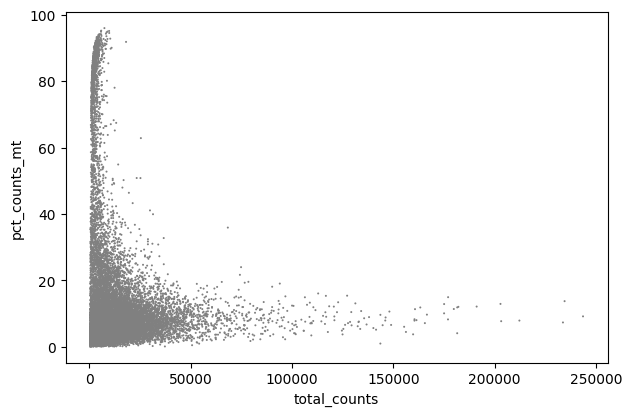

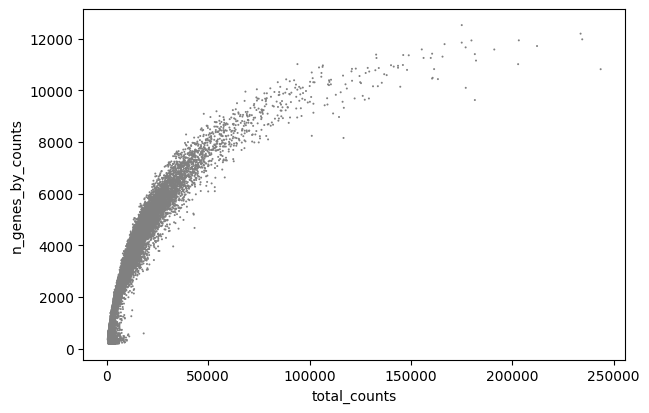

In [119]:
#Look for cells that have too many mitochondrial genes or too many counts
sc.pl.scatter(adata,x='total_counts',y='pct_counts_mt')
sc.pl.scatter(adata,x='total_counts',y='n_genes_by_counts')

In [120]:
# Filter further to remove dead/dying or empty cells
# THIS IS SUBJECTIVE AND SHOULD BE MODIFIED DEPENDING ON THE DATASET
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata,min_cells = 3)
adata = adata[adata.obs['pct_counts_mt'] < 15]
adata = adata[adata.obs['pct_counts_rb'] < 50]

## Basic Analysis

In [74]:
#Keep raw data accessible since normalizing will replace the slot containing matrix
adata.raw = adata
adata.layers['counts'] = adata.X

In [75]:
#Normalize Countsand logarithmize the data
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


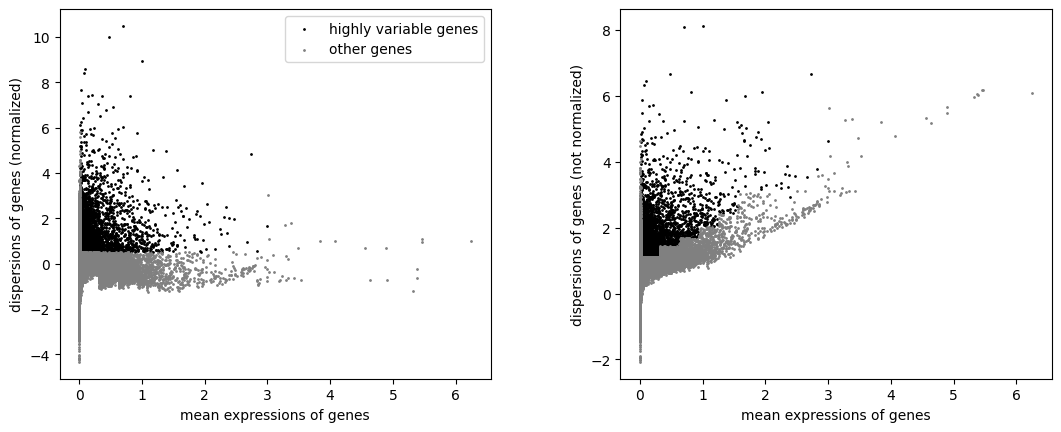

In [76]:
#Identify Highly Variable Genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#visualize 
sc.pl.highly_variable_genes(adata)

In [77]:
#subset data to contain just highly variable genes
adata = adata[:,adata.var.highly_variable]

In [78]:
#sc.pp.regress_out(adata,['total_counts','pct_counts_mt'])
sc.pp.scale(adata,max_value=10)

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Principal Component Analysis

In [79]:
sc.tl.pca(adata,svd_solver='arpack')

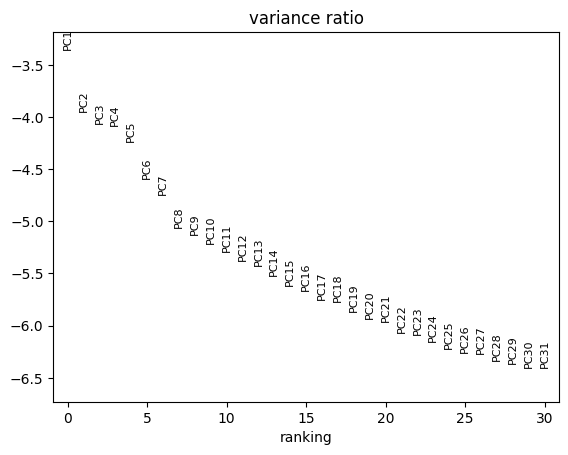

In [80]:
#Contributions of PCs to the total variance in the dataset
# Utilize this to choose the number of PCs for neighborhood analysis
sc.pl.pca_variance_ratio(adata,log=True)

## Compute Neighborhood Graph

In [81]:
sc.pp.neighbors(adata,n_neighbors=10,n_pcs=30)

In [82]:
sc.tl.umap(adata)

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


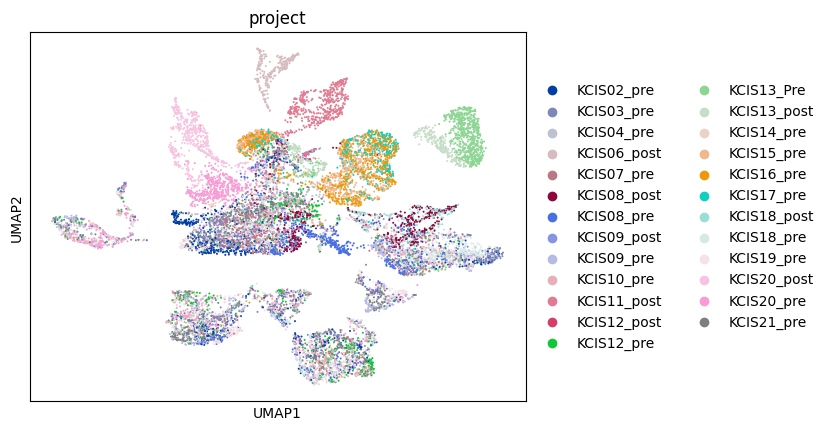

In [84]:
sc.pl.umap(adata,color = ['project'])

## Cluster Neighborhood Graph

In [87]:
#Cluster using leiden
sc.tl.leiden(
    adata,
    resolution=0.5,
    random_state=0,
    n_iterations=2,
    directed=False,
)

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


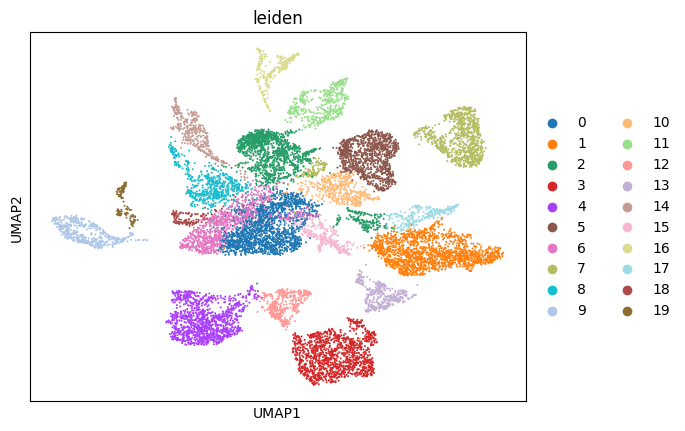

In [88]:
sc.pl.umap(adata,color='leiden')